In [2]:
pip install --upgrade numpy scipy

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy in c:\users\user-kate\appdata\local\programs\python\python39\lib\site-packages (1.21.5)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)
   ---------------------------------------- 46.2/46.2 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.1
    Uninstalling scipy-1.11.1:
      Successfully uninstalled scipy-1.11.1



  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 2.0.2 which is incompatible.


In [4]:
pip install numpy==1.24.3

  Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np

## Data Cleaning

In [2]:
demographics_data = pd.read_csv('D:/桌面/capstone new/US Zip Codes Demographics/zip_code_demographics.csv')
caserate_data = pd.read_csv('D:/桌面/capstone new/coronavirus-data/trends/caserate-by-modzcta.csv')
age_data = pd.read_csv('D:/桌面/capstone new/coronavirus-data/trends/weekly-case-rate-age.csv')
race_data = pd.read_csv('D:/桌面/capstone new/coronavirus-data/trends/weekly-case-rate-race.csv')

In [8]:
print("Caserate Data Columns:", caserate_data.columns)
print("Age Data Columns:", age_data.columns)
print("Race Data Columns:", race_data.columns)
print("Demographics Data Columns:", demographics_data.columns)

Caserate Data Columns: Index(['week_ending', 'CASERATE_CITY', 'CASERATE_BX', 'CASERATE_BK',
       'CASERATE_MN', 'CASERATE_QN', 'CASERATE_SI', 'CASERATE_10001',
       'CASERATE_10002', 'CASERATE_10003',
       ...
       'CASERATE_11432', 'CASERATE_11433', 'CASERATE_11434', 'CASERATE_11435',
       'CASERATE_11436', 'CASERATE_11691', 'CASERATE_11692', 'CASERATE_11693',
       'CASERATE_11694', 'CASERATE_11697'],
      dtype='object', length=184)
Age Data Columns: Index(['week_ending', 'age_all_ages', 'age_0_4', 'age_5_12', 'age_13_17',
       'age_18_24', 'age_25_34', 'age_35_44', 'age_45_54', 'age_55_64',
       'age_65_74', 'age_75up'],
      dtype='object')
Race Data Columns: Index(['week_ending', 'all_race_ethnicity', 'Asian_Pacific_Islander',
       'Black_African_American', 'Hispanic_Latino', 'White'],
      dtype='object')
Demographics Data Columns: Index(['zip', 'lat', 'lng', 'city', 'state_id', 'state_name', 'population',
       'density', 'county_name', 'po_box', 'dist_high

### caserate

In [9]:
# Filter columns that contain ZIP Codes (5-digit numbers)
postal_columns = [col for col in caserate_data.columns if re.match(r'CASERATE_\d{5}', col)]

# Transform the case data into long format
caserate_data_long = caserate_data.melt(
    id_vars=['week_ending'], 
    value_vars=postal_columns, 
    var_name='zip_code_column', 
    value_name='case_rate'
)

# Extract ZIP Codes
caserate_data_long['zip_code'] = caserate_data_long['zip_code_column'].str.split('_').str[1]

### age and race

In [10]:
# Check for missing values
print("Age Data Missing Values:", age_data.isnull().sum())
print("Race Data Missing Values:", race_data.isnull().sum())

# Ensure date format consistency
age_data['week_ending'] = pd.to_datetime(age_data['week_ending'])
race_data['week_ending'] = pd.to_datetime(race_data['week_ending'])

Age Data Missing Values: week_ending     0
age_all_ages    1
age_0_4         1
age_5_12        1
age_13_17       0
age_18_24       1
age_25_34       1
age_35_44       2
age_45_54       0
age_55_64       1
age_65_74       1
age_75up        1
dtype: int64
Race Data Missing Values: week_ending               0
all_race_ethnicity        0
Asian_Pacific_Islander    1
Black_African_American    1
Hispanic_Latino           1
White                     0
dtype: int64


### demographics

In [11]:
# Check for missing values
print("Demographics Data Missing Values:", demographics_data.isnull().sum())

# Ensure ZIP Codes are consistently formatted as strings
caserate_data_long['zip_code'] = caserate_data_long['zip_code'].astype(str)
demographics_data['zip'] = demographics_data['zip'].astype(str)

Demographics Data Missing Values: zip                       0
lat                       0
lng                       0
city                      0
state_id                  0
state_name                0
population                0
density                   0
county_name               0
po_box                    0
dist_highway              0
dist2_large_airport       0
dist2_medium_airport      0
dist_to_shore             0
number_of_business       80
adjusted_gross_income     0
total_income_amount       0
number_of_returns         0
dtype: int64


### Year 2020

In [12]:
# Ensure week_ending is consistently formatted as datetime
caserate_data_long['week_ending'] = pd.to_datetime(caserate_data_long['week_ending'])

# Filter data for the year 2020
caserate_data_long = caserate_data_long[caserate_data_long['week_ending'].dt.year == 2020]
age_data = age_data[age_data['week_ending'].dt.year == 2020]
race_data = race_data[race_data['week_ending'].dt.year == 2020]

### Data Combined

In [13]:
# Merge datasets by ZIP Code and date
combined_data = caserate_data_long.merge(
    demographics_data, left_on='zip_code', right_on='zip', how='inner'
).merge(
    age_data, on='week_ending', how='inner'
).merge(
    race_data, on='week_ending', how='inner'
)

# Remove missing values
combined_data = combined_data.dropna()

# Verify the merged data
print(combined_data.head())
print(combined_data.info())

    week_ending zip_code_column  case_rate zip_code    zip       lat  \
354  2020-03-21  CASERATE_10001     217.29    10001  10001  40.75000   
355  2020-03-21  CASERATE_10002     179.23    10002  10002  40.71597   
356  2020-03-21  CASERATE_10003     222.31    10003  10003  40.73000   
357  2020-03-21  CASERATE_10004     336.46    10004  10004  40.69000   
358  2020-03-21  CASERATE_10005     171.29    10005  10005  40.71000   

          lng      city state_id state_name  ...  age_35_44  age_45_54  \
354 -74.00000  New York       NY   New York  ...     322.28     315.34   
355 -73.98692  New York       NY   New York  ...     322.28     315.34   
356 -73.99000  New York       NY   New York  ...     322.28     315.34   
357 -74.02000  New York       NY   New York  ...     322.28     315.34   
358 -74.01000  New York       NY   New York  ...     322.28     315.34   

    age_55_64  age_65_74  age_75up  all_race_ethnicity  \
354    304.33     269.34    228.09              191.58   
355   

### Create New Variable

In [14]:
# Sort data by ZIP Code and date
combined_data = combined_data.sort_values(by=['zip_code', 'week_ending'])

# Generate lagged case rates (previous week's data)
combined_data['lagged_case_rate'] = combined_data.groupby('zip_code')['case_rate'].shift(1)

# Remove rows where lagged variables cannot be calculated
combined_data = combined_data.dropna(subset=['lagged_case_rate'])

# Final data inspection
print(combined_data.head())
print(combined_data.info())

     week_ending zip_code_column  case_rate zip_code    zip    lat   lng  \
531   2020-03-28  CASERATE_10001     148.48    10001  10001  40.75 -74.0   
708   2020-04-04  CASERATE_10001     206.42    10001  10001  40.75 -74.0   
885   2020-04-11  CASERATE_10001     162.97    10001  10001  40.75 -74.0   
1062  2020-04-18  CASERATE_10001      83.29    10001  10001  40.75 -74.0   
1239  2020-04-25  CASERATE_10001      79.67    10001  10001  40.75 -74.0   

          city state_id state_name  ...  age_45_54  age_55_64 age_65_74  \
531   New York       NY   New York  ...     482.55     525.36    491.80   
708   New York       NY   New York  ...     610.36     669.22    667.78   
885   New York       NY   New York  ...     580.88     682.93    654.57   
1062  New York       NY   New York  ...     398.99     458.89    436.56   
1239  New York       NY   New York  ...     338.98     370.90    335.42   

      age_75up  all_race_ethnicity  Asian_Pacific_Islander  \
531     546.64              29

In [15]:
output_path = 'D:/桌面/capstone new/combined_data.csv'
combined_data.to_csv(output_path, index=False)

In [16]:
print(combined_data.columns)

Index(['week_ending', 'zip_code_column', 'case_rate', 'zip_code', 'zip', 'lat',
       'lng', 'city', 'state_id', 'state_name', 'population', 'density',
       'county_name', 'po_box', 'dist_highway', 'dist2_large_airport',
       'dist2_medium_airport', 'dist_to_shore', 'number_of_business',
       'adjusted_gross_income', 'total_income_amount', 'number_of_returns',
       'age_all_ages', 'age_0_4', 'age_5_12', 'age_13_17', 'age_18_24',
       'age_25_34', 'age_35_44', 'age_45_54', 'age_55_64', 'age_65_74',
       'age_75up', 'all_race_ethnicity', 'Asian_Pacific_Islander',
       'Black_African_American', 'Hispanic_Latino', 'White',
       'lagged_case_rate'],
      dtype='object')


## Trend Plot

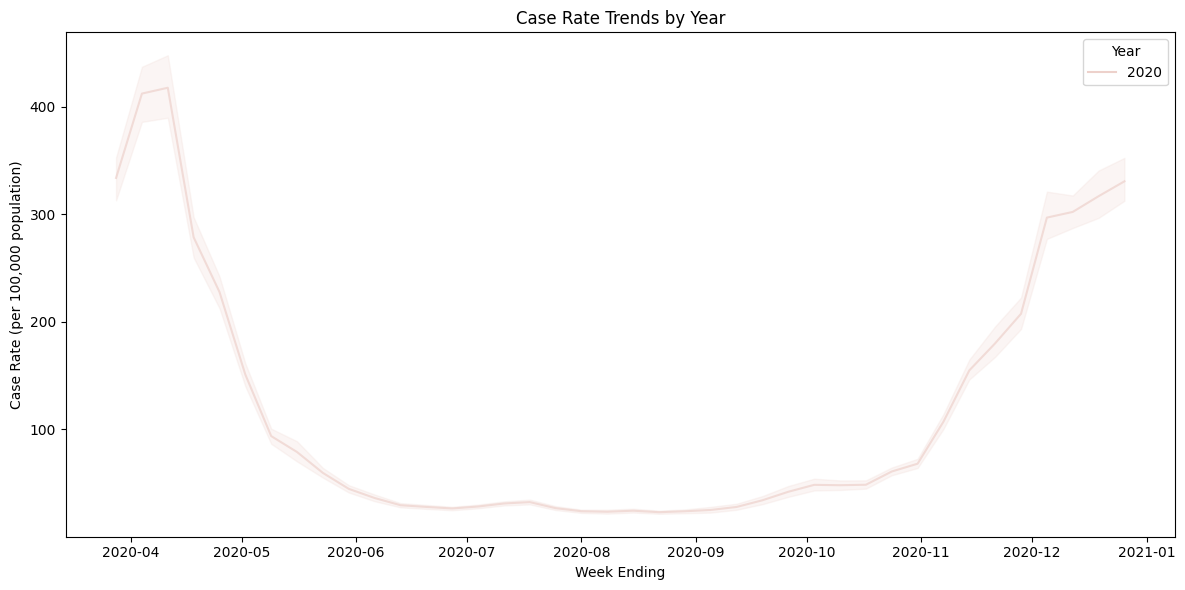

In [17]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_data, x='week_ending', y='case_rate', hue=combined_data['week_ending'].dt.year, alpha=0.7)
plt.title('Case Rate Trends by Year')
plt.xlabel('Week Ending')
plt.ylabel('Case Rate (per 100,000 population)')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

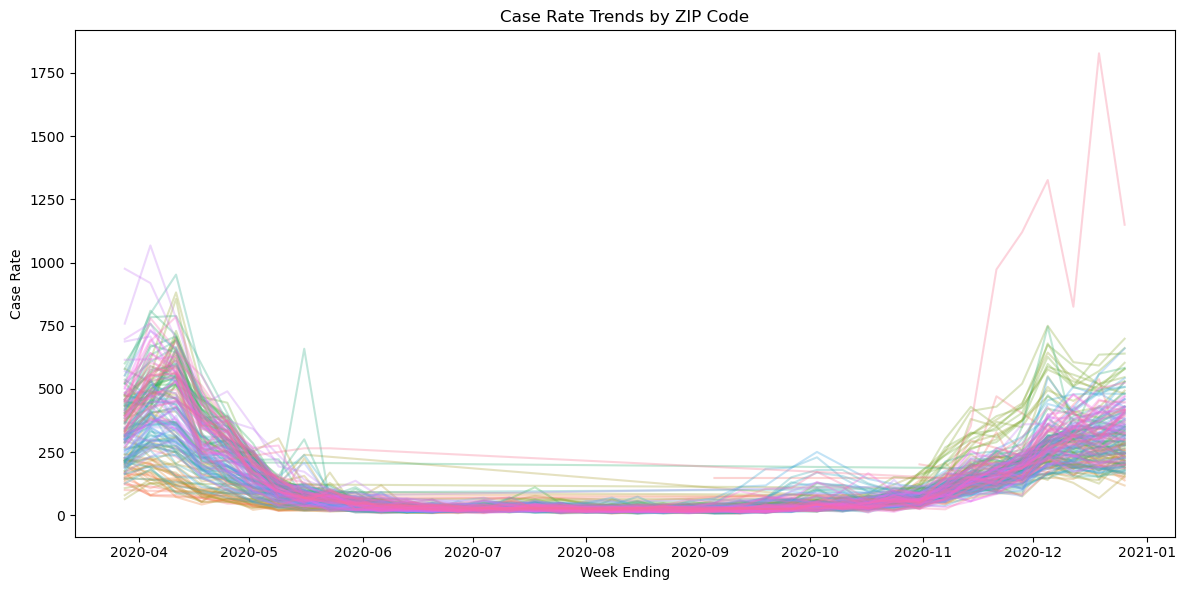

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_data, x='week_ending', y='case_rate', hue='zip_code', legend=False, alpha=0.3)
plt.title('Case Rate Trends by ZIP Code')
plt.xlabel('Week Ending')
plt.ylabel('Case Rate')
plt.tight_layout()
plt.show()

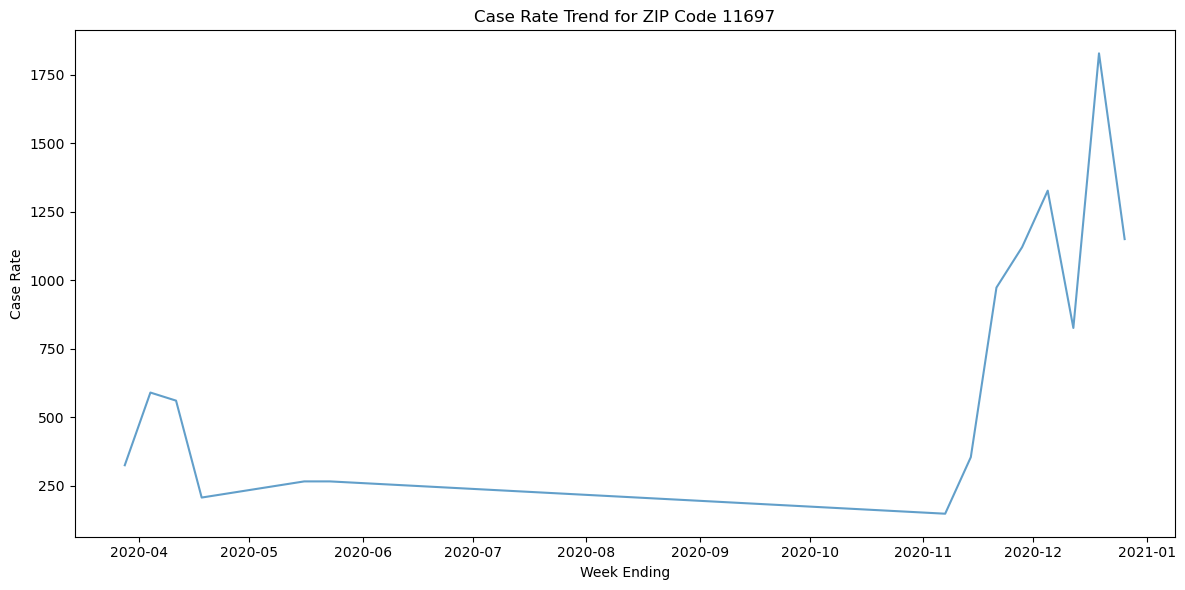

11697


In [14]:
# plot December 2020 case rate highest zipcode
zipcode = combined_data[combined_data['week_ending'].dt.month == 12].sort_values(by='case_rate', ascending=False).iloc[0]['zip_code']
zipcode_data = combined_data[combined_data['zip_code'] == zipcode]

plt.figure(figsize=(12, 6))
sns.lineplot(data=zipcode_data, x='week_ending', y='case_rate', alpha=0.7)
plt.title(f'Case Rate Trend for ZIP Code {zipcode}')
plt.xlabel('Week Ending')
plt.ylabel('Case Rate')
plt.tight_layout()
plt.show()

print(zipcode)

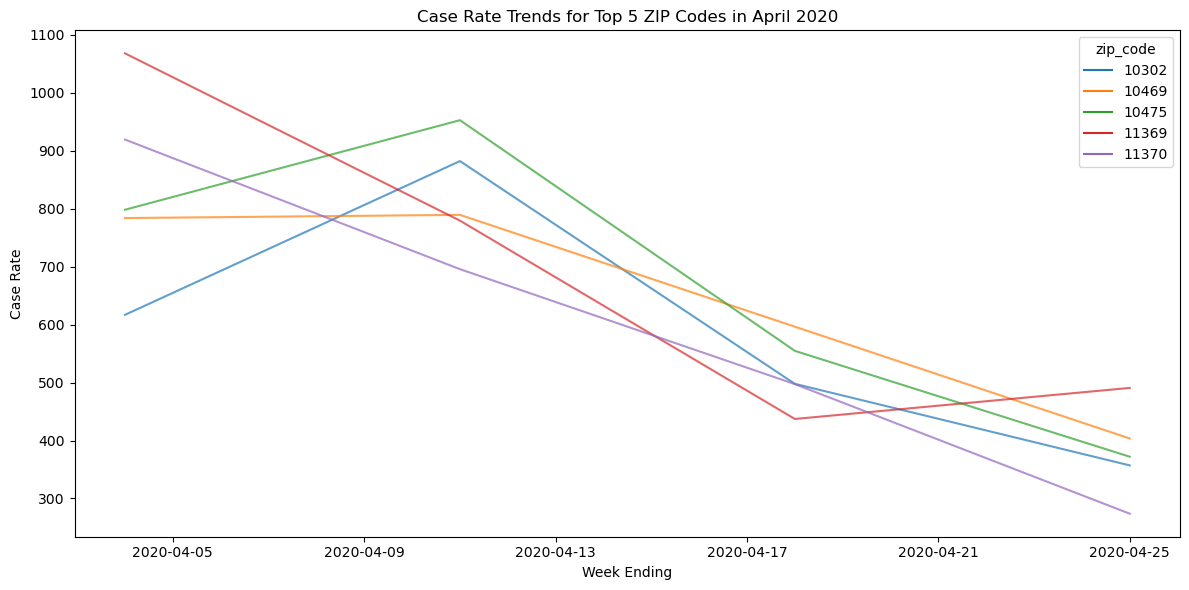

In [15]:
# Filter data for April 2020, and identify the top 5 ZIP Codes by case rate
april_data = combined_data[combined_data['week_ending'].dt.month == 4]
top_zipcodes = april_data.groupby('zip_code')['case_rate'].mean().sort_values(ascending=False).head(5).index
top_zipcode_data = april_data[april_data['zip_code'].isin(top_zipcodes)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_zipcode_data, x='week_ending', y='case_rate', hue='zip_code', alpha=0.7)
plt.title('Case Rate Trends for Top 5 ZIP Codes in April 2020')
plt.xlabel('Week Ending')
plt.ylabel('Case Rate')
plt.tight_layout()
plt.show()

In [12]:
combined_data.head()

week_ending zip_code_column  case_rate zip_code    zip    lat   lng  \
531   2020-03-28  CASERATE_10001     148.48    10001  10001  40.75 -74.0   
708   2020-04-04  CASERATE_10001     206.42    10001  10001  40.75 -74.0   
885   2020-04-11  CASERATE_10001     162.97    10001  10001  40.75 -74.0   
1062  2020-04-18  CASERATE_10001      83.29    10001  10001  40.75 -74.0   
1239  2020-04-25  CASERATE_10001      79.67    10001  10001  40.75 -74.0   

          city state_id state_name  ...  age_45_54  age_55_64 age_65_74  \
531   New York       NY   New York  ...     482.55     525.36    491.80   
708   New York       NY   New York  ...     610.36     669.22    667.78   
885   New York       NY   New York  ...     580.88     682.93    654.57   
1062  New York       NY   New York  ...     398.99     458.89    436.56   
1239  New York       NY   New York  ...     338.98     370.90    335.42   

      age_75up  all_race_ethnicity  Asian_Pacific_Islander  \
531     546.64              299.21                  135.31   
708     807.50              370.91                  187.85   
885     927.16              360.11                  208.44   
1062    674.67              232.21                  132.94   
1239    464.91              179.79                   97.34   

      Black_African_American  Hispanic_Latino   White  lagged_case_rate  
531                   334.45           351.18  244.26            217.29  
708                   433.65           450.73  263.14            148.48  
885                   426.38           436.34  237.06            206.42  
1062                  273.10           299.70  140.31            162.97  
1239                  201.06           246.41  111.60             83.29  

[5 rows x 39 columns]

In [11]:
combined_data[combined_data.week_ending == '2020-04-04']

week_ending zip_code_column  case_rate zip_code    zip       lat  \
708  2020-04-04  CASERATE_10001     206.42    10001  10001  40.75000   
709  2020-04-04  CASERATE_10002     258.89    10002  10002  40.71597   
710  2020-04-04  CASERATE_10003     114.86    10003  10003  40.73000   
712  2020-04-04  CASERATE_10005      79.93    10005  10005  40.71000   
715  2020-04-04  CASERATE_10009     225.72    10009  10009  40.72639   
..          ...             ...        ...      ...    ...       ...   
880  2020-04-04  CASERATE_11691     556.42    11691  11691  40.60152   
881  2020-04-04  CASERATE_11692     551.62    11692  11692  40.59373   
882  2020-04-04  CASERATE_11693     544.50    11693  11693  40.59649   
883  2020-04-04  CASERATE_11694     543.81    11694  11694  40.58000   
884  2020-04-04  CASERATE_11697     589.52    11697  11697  40.55749   

          lng           city state_id state_name  ...  age_45_54  age_55_64  \
708 -74.00000       New York       NY   New York  ...     610.36     669.22   
709 -73.98692       New York       NY   New York  ...     610.36     669.22   
710 -73.99000       New York       NY   New York  ...     610.36     669.22   
712 -74.01000       New York       NY   New York  ...     610.36     669.22   
715 -73.97865       New York       NY   New York  ...     610.36     669.22   
..        ...            ...      ...        ...  ...        ...        ...   
880 -73.76173   Far Rockaway       NY   New York  ...     610.36     669.22   
881 -73.79201        Arverne       NY   New York  ...     610.36     669.22   
882 -73.81663   Far Rockaway       NY   New York  ...     610.36     669.22   
883 -73.84000  Rockaway Park       NY   New York  ...     610.36     669.22   
884 -73.91361   Breezy Point       NY   New York  ...     610.36     669.22   

    age_65_74  age_75up  all_race_ethnicity  Asian_Pacific_Islander  \
708    667.78     807.5              370.91                  187.85   
709    667.78     807.5              370.91                  187.85   
710    667.78     807.5              370.91                  187.85   
712    667.78     807.5              370.91                  187.85   
715    667.78     807.5              370.91                  187.85   
..        ...       ...                 ...                     ...   
880    667.78     807.5              370.91                  187.85   
881    667.78     807.5              370.91                  187.85   
882    667.78     807.5              370.91                  187.85   
883    667.78     807.5              370.91                  187.85   
884    667.78     807.5              370.91                  187.85   

     Black_African_American  Hispanic_Latino   White  lagged_case_rate  
708                  433.65           450.73  263.14            148.48  
709                  433.65           450.73  263.14            203.13  
710                  433.65           450.73  263.14            122.27  
712                  433.65           450.73  263.14            125.61  
715                  433.65           450.73  263.14            215.22  
..                      ...              ...     ...               ...  
880                  433.65           450.73  263.14            459.19  
881                  433.65           450.73  263.14            332.87  
882                  433.65           450.73  263.14            394.57  
883                  433.65           450.73  263.14            394.62  
884                  433.65           450.73  263.14            324.23  

[174 rows x 39 columns]

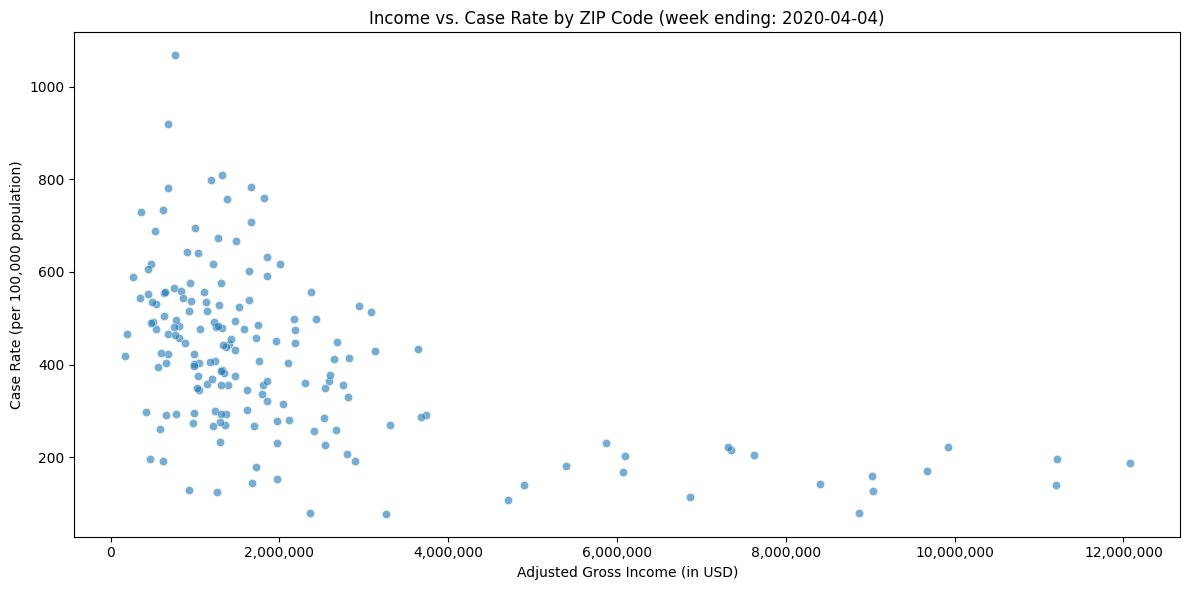

In [12]:
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 6))
sns.scatterplot(data=combined_data[combined_data.week_ending == '2020-04-04'], 
                x='adjusted_gross_income', y='case_rate', alpha=0.6)
plt.title('Income vs. Case Rate by ZIP Code (week ending: 2020-04-04)')
plt.xlabel('Adjusted Gross Income (in USD)')
plt.ylabel('Case Rate (per 100,000 population)')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

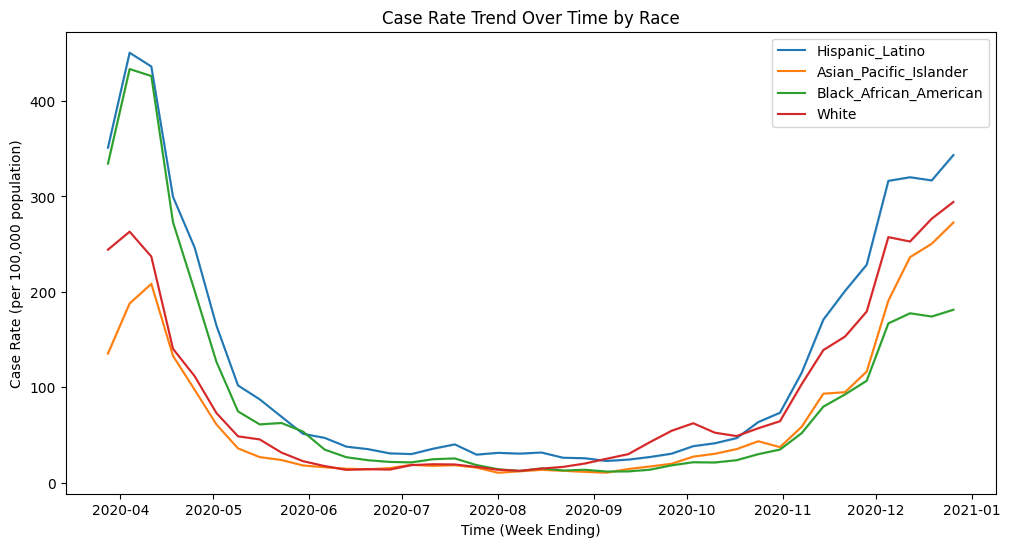

In [13]:
plt.figure(figsize=(12, 6))
for feature in ["Hispanic_Latino", "Asian_Pacific_Islander", "Black_African_American", "White"]:
    sns.lineplot(data=combined_data, x="week_ending", y=feature, label=feature)
plt.title("Case Rate Trend Over Time by Race")
plt.xlabel("Time (Week Ending)")
plt.ylabel("Case Rate (per 100,000 population)")
plt.legend()
plt.show()

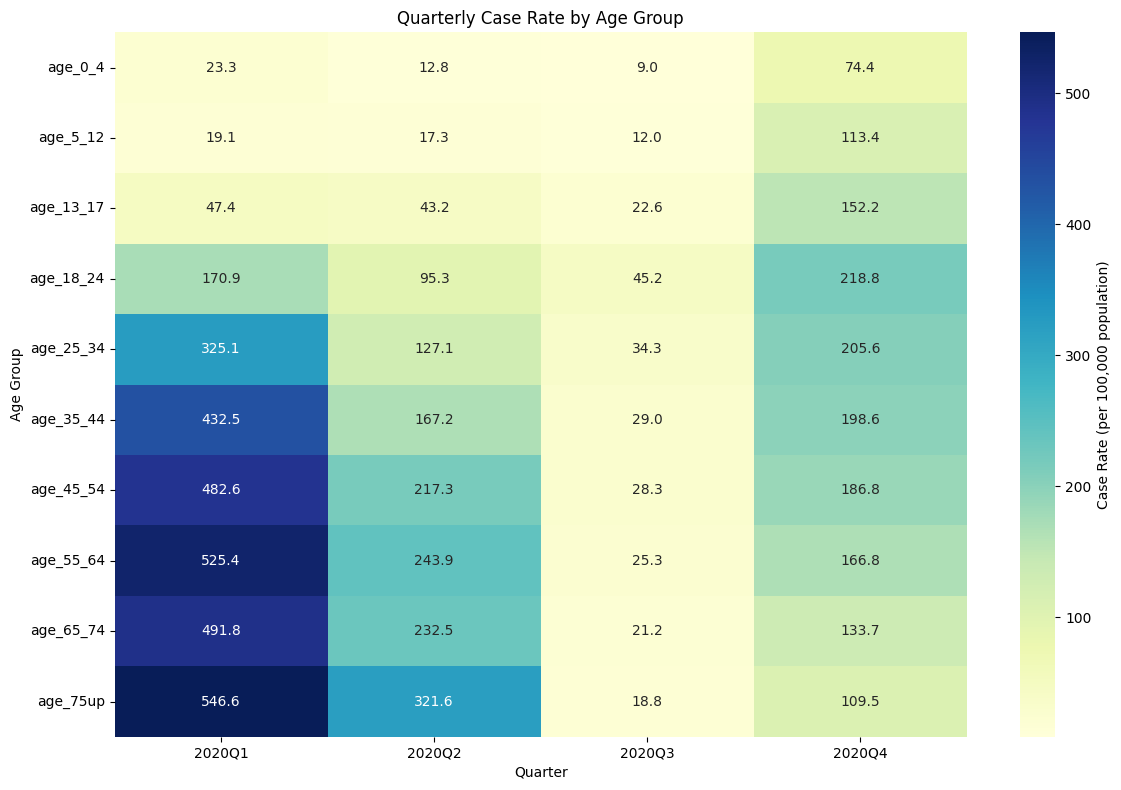

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

combined_data['quarter'] = combined_data['week_ending'].dt.to_period('Q')

heatmap_data = combined_data.groupby('quarter')[
    ["age_0_4", "age_5_12", "age_13_17", "age_18_24", "age_25_34", 
     "age_35_44", "age_45_54", "age_55_64", "age_65_74", "age_75up"]
].mean().T

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Case Rate (per 100,000 population)'})
plt.title("Quarterly Case Rate by Age Group")
plt.xlabel("Quarter")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()

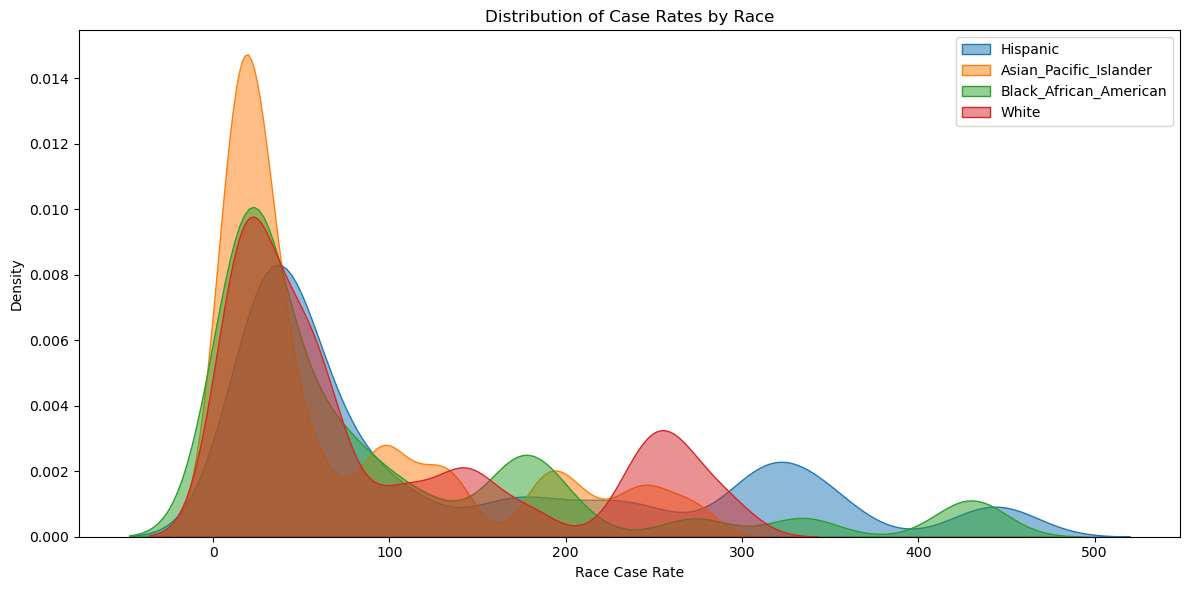

In [16]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=combined_data, x='Hispanic_Latino', label='Hispanic', fill=True, alpha=0.5)
sns.kdeplot(data=combined_data, x='Asian_Pacific_Islander', label='Asian_Pacific_Islander', fill=True, alpha=0.5)
sns.kdeplot(data=combined_data, x='Black_African_American', label='Black_African_American', fill=True, alpha=0.5)
sns.kdeplot(data=combined_data, x='White', label='White', fill=True, alpha=0.5)
plt.title('Distribution of Case Rates by Race')
plt.xlabel('Race Case Rate')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
import plotly.express as px

fig = px.scatter(
    combined_data,
    x='adjusted_gross_income',
    y='case_rate',
    size='case_rate',
    color='Hispanic_Latino',
    hover_data=['zip_code', 'density', 'population'],
    title='Case Rate vs Adjusted Gross Income (Sized by Case Rate)',
    labels={'adjusted_gross_income': 'Adjusted Gross Income', 'case_rate': 'Case Rate'}
)

fig.update_layout(
    width=900,
    height=600
)

fig.show()

In [20]:
!pip install geopandas

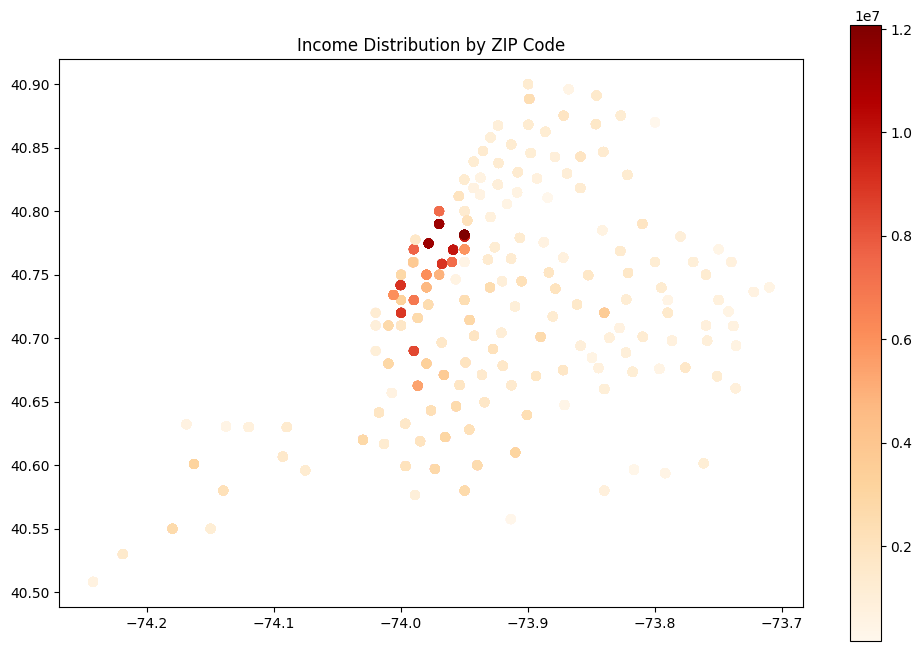

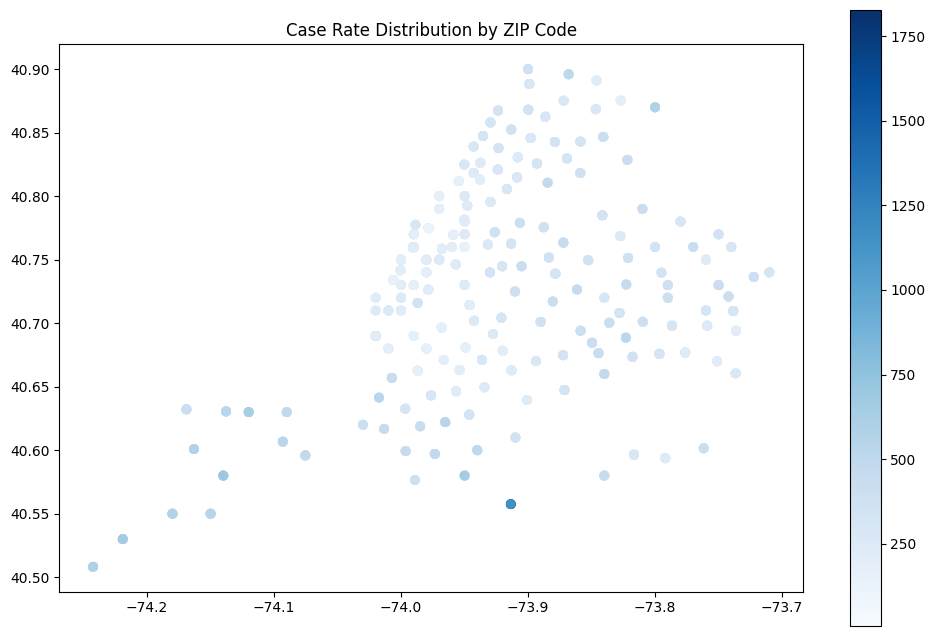

In [21]:
import geopandas as gpd

# create GeoDataFrame
gdf = gpd.GeoDataFrame(combined_data, geometry=gpd.points_from_xy(combined_data['lng'], combined_data['lat']))

# income distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.plot(column='adjusted_gross_income', cmap='OrRd', legend=True, ax=ax)
plt.title('Income Distribution by ZIP Code')
plt.show()

# case rate distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.plot(column='case_rate', cmap='Blues', legend=True, ax=ax)
plt.title('Case Rate Distribution by ZIP Code')
plt.show()

In [19]:
import plotly.express as px

high_case_threshold = combined_data['case_rate'].quantile(0.9)
high_case_data = combined_data[combined_data['case_rate'] >= high_case_threshold]

fig = px.histogram(
    combined_data,
    x='density',
    nbins=50,
    title='Population Density Distribution with High Case Rate Highlighted',
    labels={'density': 'Population Density'},
    marginal="box"
)

fig.add_scatter(
    x=high_case_data['density'],
    y=[0] * len(high_case_data),
    mode='markers',
    marker=dict(size=10, color='red'),
    name='High Case Rate'
)

fig.show()

In [21]:
fig = px.scatter_mapbox(
    combined_data,
    lat='lat',
    lon='lng',
    color='case_rate',
    size='case_rate',
    hover_name='zip_code',
    hover_data=['density', 'population'],
    mapbox_style='carto-positron',
    title='Case Rate by ZIP Code',
    labels={'case_rate': 'Case Rate'},
    zoom=10
)

fig.show()

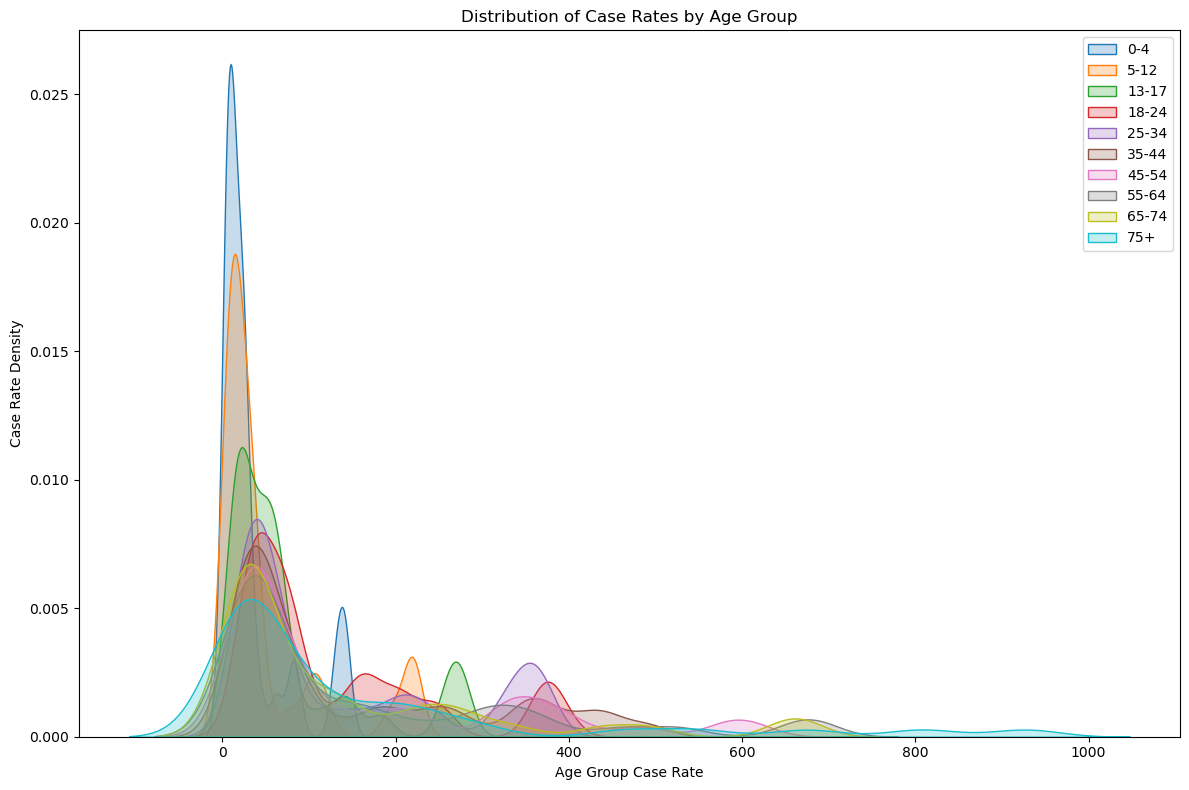

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.kdeplot(data=combined_data, x='age_0_4', label='0-4', fill=True, ax=ax)
sns.kdeplot(data=combined_data, x='age_5_12', label='5-12', fill=True, ax=ax)
sns.kdeplot(data=combined_data, x='age_13_17', label='13-17', fill=True, ax=ax)
sns.kdeplot(data=combined_data, x='age_18_24', label='18-24', fill=True, ax=ax)
sns.kdeplot(data=combined_data, x='age_25_34', label='25-34', fill=True, ax=ax)
sns.kdeplot(data=combined_data, x='age_35_44', label='35-44', fill=True, ax=ax)
sns.kdeplot(data=combined_data, x='age_45_54', label='45-54', fill=True, ax=ax)
sns.kdeplot(data=combined_data, x='age_55_64', label='55-64', fill=True, ax=ax)
sns.kdeplot(data=combined_data, x='age_65_74', label='65-74', fill=True, ax=ax)
sns.kdeplot(data=combined_data, x='age_75up', label='75+', fill=True, ax=ax)
plt.title('Distribution of Case Rates by Age Group')
plt.xlabel('Age Group Case Rate')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## Regression

### Univariate

- Display basic information about income-related variables

In [21]:
print(combined_data[['adjusted_gross_income', 'total_income_amount', 'number_of_returns']].info())
print(combined_data[['adjusted_gross_income', 'total_income_amount', 'number_of_returns']].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6191 entries, 531 to 7610
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adjusted_gross_income  6191 non-null   int64  
 1   total_income_amount    6191 non-null   float64
 2   number_of_returns      6191 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 193.5 KB
None
       adjusted_gross_income  total_income_amount  number_of_returns
count           6.191000e+03         6.191000e+03        6191.000000
mean            2.208431e+06         2.232105e+06       25892.159586
std             2.267650e+06         2.294897e+06       12308.487670
min             1.676110e+05         1.688640e+05        1990.000000
25%             9.937250e+05         1.004211e+06       16270.000000
50%             1.400926e+06         1.415837e+06       24010.000000
75%             2.414821e+06         2.444781e+06       34530.000000
max             1.20752

In [22]:
combined_data_2 = combined_data[combined_data.week_ending == '2020-04-04']

In [23]:
X_income = sm.add_constant(combined_data_2[['adjusted_gross_income']])  # Independent variables, add intercept
Y_case_rate = combined_data_2['case_rate']  # Dependent variable

model_income = sm.OLS(Y_case_rate, X_income).fit()
print(model_income.summary())

                            OLS Regression Results                            
Dep. Variable:              case_rate   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     63.40
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           2.20e-13
Time:                        20:57:13   Log-Likelihood:                -1120.9
No. Observations:                 174   AIC:                             2246.
Df Residuals:                     172   BIC:                             2252.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   499.46

### Multivariate

In [24]:
# choose the data of a specific week
week_data = combined_data_2[combined_data_2['week_ending'] == '2020-04-04']

# create a regression model
X_week = week_data[['adjusted_gross_income', 'density', 'age_18_24', 'age_65_74', 'White', 'Hispanic_Latino']]
X_week = sm.add_constant(X_week)
Y_week = week_data['case_rate']

model_week = sm.OLS(Y_week, X_week).fit()
print(model_week.summary())

                            OLS Regression Results                            
Dep. Variable:              case_rate   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     44.86
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           2.18e-16
Time:                        20:57:21   Log-Likelihood:                -1111.5
No. Observations:                 174   AIC:                             2229.
Df Residuals:                     171   BIC:                             2239.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
adjusted_gross_income -2.957e-

### log

In [38]:
# use 2020-04-04 data, combined_data_2 and log to do regression analysis
combined_data_2['log_case_rate'] = np.log(combined_data_2['case_rate'])
combined_data_2['log_adjusted_gross_income'] = np.log(combined_data_2['adjusted_gross_income'])
combined_data_2['log_income'] = np.log(combined_data_2['total_income_amount'])
combined_data_2['log_density'] = np.log(combined_data_2['density'])
combined_data_2['log_age_18_24'] = np.log(combined_data_2['age_18_24'])
combined_data_2['log_age_65_74'] = np.log(combined_data_2['age_65_74'])
combined_data_2['log_White'] = np.log(combined_data_2['White'])
combined_data_2['log_Hispanic_Latino'] = np.log(combined_data_2['Hispanic_Latino'])

# lagger case rate
combined_data_2['lagged_log_case_rate'] = combined_data_2.groupby('zip_code')['log_case_rate'].shift(1)

# income_hispanic_interaction
combined_data_2['income_hispanic_interaction'] = combined_data_2['log_adjusted_gross_income'] * combined_data_2['log_Hispanic_Latino']

In [26]:
# independent variables and add a constant term
X_with_lagged = sm.add_constant(combined_data_2[['log_income', 'Hispanic_Latino', 'income_hispanic_interaction', 'lagged_case_rate']])
Y_case_rate = combined_data_2['case_rate']

model_with_lagged = sm.OLS(Y_case_rate, X_with_lagged).fit()

print(model_with_lagged.summary())

                            OLS Regression Results                            
Dep. Variable:              case_rate   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     264.0
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           9.88e-64
Time:                        22:15:41   Log-Likelihood:                -997.45
No. Observations:                 174   AIC:                             2003.
Df Residuals:                     170   BIC:                             2016.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
log_income        

In [28]:
combined_data_2['log_population'] = np.log(combined_data_2['population'] + 1)
combined_data_2['log_density'] = np.log(combined_data_2['density'] + 1)

X_updated = combined_data_2[['log_income', 'Hispanic_Latino', 
                            'lagged_case_rate', 'log_population', 'log_density', 
                            'age_65_74', 'age_75up']]
X_updated = sm.add_constant(X_updated)
model_updated = sm.OLS(Y_case_rate, X_updated).fit(cov_type='HC3')
print(model_updated.summary())

                            OLS Regression Results                            
Dep. Variable:              case_rate   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1432.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):          2.62e-136
Time:                        22:16:31   Log-Likelihood:                -988.77
No. Observations:                 174   AIC:                             1988.
Df Residuals:                     169   BIC:                             2003.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
log_income         -73.0642      7.829  

C:\Users\User-Kate\AppData\Local\Temp\ipykernel_6736\3866643523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data_2['log_population'] = np.log(combined_data_2['population'] + 1)
C:\Users\User-Kate\AppData\Local\Temp\ipykernel_6736\3866643523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data_2['log_density'] = np.log(combined_data_2['density'] + 1)
c:\Users\User-Kate\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not ha

### Nov and Dec

In [29]:
# Filter data for November and December 2020
combined_data_3 = combined_data[
    (combined_data['week_ending'] >= '2020-11-01') & 
    (combined_data['week_ending'] <= '2020-12-31')
]

# log
combined_data_3['log_case_rate'] = np.log(combined_data_3['case_rate'])
combined_data_3['log_adjusted_gross_income'] = np.log(combined_data_3['adjusted_gross_income'])
combined_data_3['log_income'] = np.log(combined_data_3['total_income_amount'])
combined_data_3['log_density'] = np.log(combined_data_3['density'])
combined_data_3['log_age_18_24'] = np.log(combined_data_3['age_18_24'])
combined_data_3['log_age_65_74'] = np.log(combined_data_3['age_65_74'])
combined_data_3['log_White'] = np.log(combined_data_3['White'])
combined_data_3['log_Hispanic_Latino'] = np.log(combined_data_3['Hispanic_Latino'])

# lagger case rate
combined_data_3['lagged_log_case_rate'] = combined_data_3.groupby('zip_code')['log_case_rate'].shift(1)

# income_hispanic_interaction
combined_data_3['income_hispanic_interaction'] = combined_data_3['log_adjusted_gross_income'] * combined_data_3['log_Hispanic_Latino']

X_with_lagged = sm.add_constant(combined_data_3[['log_income', 'Hispanic_Latino', 'income_hispanic_interaction', 'lagged_case_rate']])
Y_case_rate = combined_data_3['case_rate']

model_with_lagged = sm.OLS(Y_case_rate, X_with_lagged).fit()

print(model_with_lagged.summary())

C:\Users\User-Kate\AppData\Local\Temp\ipykernel_6736\1937528318.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data_3['log_case_rate'] = np.log(combined_data_3['case_rate'])
C:\Users\User-Kate\AppData\Local\Temp\ipykernel_6736\1937528318.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data_3['log_adjusted_gross_income'] = np.log(combined_data_3['adjusted_gross_income'])
C:\Users\User-Kate\AppData\Local\Temp\ipykernel_6736\1937528318.py:10: SettingWithCopyWarning: 
A value is tryin

                            OLS Regression Results                            
Dep. Variable:              case_rate   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     1021.
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:16:52   Log-Likelihood:                -7939.5
No. Observations:                1406   AIC:                         1.589e+04
Df Residuals:                    1401   BIC:                         1.592e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [30]:
combined_data_3['age_65_up'] = combined_data_3['age_65_74'] + combined_data_3['age_75up']
X_simplified = combined_data_3[['log_income', 'Hispanic_Latino', 'income_hispanic_interaction',
                              'lagged_case_rate', 'log_density', 'age_65_up']]
                              
X_simplified = sm.add_constant(X_simplified)
model_simplified = sm.OLS(Y_case_rate, X_simplified).fit(cov_type='HC3')
print(model_simplified.summary())

                            OLS Regression Results                            
Dep. Variable:              case_rate   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     534.0
Date:                Tue, 03 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:17:12   Log-Likelihood:                -7863.9
No. Observations:                1406   AIC:                         1.574e+04
Df Residuals:                    1399   BIC:                         1.578e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

C:\Users\User-Kate\AppData\Local\Temp\ipykernel_6736\2537781453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data_3['age_65_up'] = combined_data_3['age_65_74'] + combined_data_3['age_75up']
